# SVM Base Learner

## Importing Libraries

In [14]:
import pandas as pd
import numpy as np
import mne
import os
import re
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mne.channels import make_standard_montage
from mne import pick_types
from mne.decoding import CSP
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.metrics import confusion_matrix
from GA_data_preprocessing import *

dir_address = "../../grasp-and-lift-eeg-detection"


raw_train = get_train_data(1,1,dir_address)
raw_filtered = get_train_data(1,1,dir_address)

## Filtering

In [15]:
# ---------- Creating filtered and unfiltered data sets --------
scaling = {"eeg":5e-4}
print("Train")
unfiltered_data = raw_train.to_data_frame()
raw_filtered = raw_filtered.filter(l_freq=0, h_freq= 30, method='fir',phase="minimum",verbose=True)
plt.show() 
# -------- other filtering method -------- (manual)

# import seaborn as sns
# def is_odd(num):
#     return num % 2 != 0


# sns.set()
# plt.figure(figsize=(15,15))
# filter_params = mne.filter.create_filter(raw_train.get_data(), raw_train.info['sfreq'],
#                                          l_freq=None, h_freq=30,phase='minimum')
# x,time = raw_train['all']
# odd = is_odd(len(filter_params))
# filter_stop = -2*(not odd) + 0*(odd)
# x_processed = np.convolve(filter_params, x[0])
# plt.plot(time.T,x[0],label='unprocessed')
# plt.plot(time.T,x_processed)
# plt.ylim([-0.0004,0.0004])
# mne.viz.plot_filter(filter_params, raw_train.info['sfreq'], flim=(0.01, 30),show=False)
# plt.show()

Train
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, non-linear phase, causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper transition bandwidth: 7.50 Hz
- Filter length: 221 samples (0.442 sec)



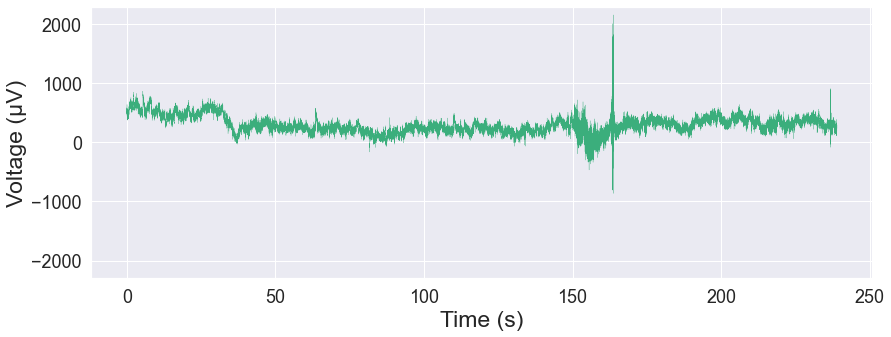

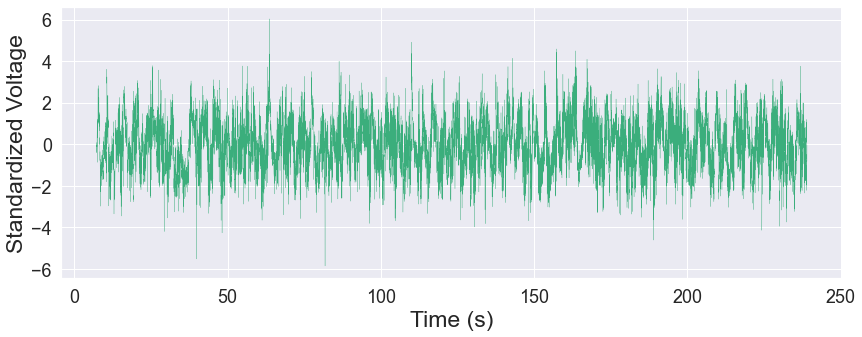

In [36]:
# ---------- Plotting ----------
sns.set('poster','white')
window_size = 1000
unfiltered_data = raw_train.to_data_frame()
filtered_data = raw_filtered.to_data_frame()
filtered_X = raw_filtered.to_data_frame().drop(['time'],axis=1)
filtered_standardized = ((filtered_X - filtered_X.rolling(window_size).mean()) / filtered_X.rolling(window_size).std()).dropna()
    
size = 1 
# # ------- Easy method ---------
# raw_train.plot(scalings=scaling,show=False,n_channels=1,duration=5)
# raw_filtered.plot(scalings=scaling,n_channels=1,show=False,duration=5)
# # ------- Hard method
sns.set()
plt.figure(figsize=(14,5))
# # # ------- Unfiltered data -------
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.ylim([-2300,2300])

unfiltered_data['time'] = unfiltered_data.time/1000
sns.lineplot(x='time',y='C4',data=unfiltered_data,lw=0.25,color='#3BAE7C')
plt.xlabel('Time (s)',fontsize=23)
plt.ylabel('Voltage (µV)',fontsize=23)
# # # ------- Filtered data --------- 
# plt.subplot(3,1,2)
# plt.yticks(fontsize=18)
# plt.xticks(fontsize=18)
# plt.ylim([-1500,1500])
# filtered_data['time'] = filtered_data.time/1000
# sns.lineplot(x='time',y='C4',data=filtered_data)
# plt.xlabel('Time (s)',fontsize=23)
# plt.ylabel('Voltage (mV)',fontsize=23)
# # # -------- Standardized data ----------

plt.figure(figsize=(14,5))
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
time = filtered_data.time.iloc[window_size-1:]/1000
sns.lineplot(x=time,y=filtered_standardized['C4'],lw=0.25,color='#3BAE7C')
plt.xlabel('Time (s)',fontsize=23)
plt.ylabel('Standardized Voltage',fontsize=23)
# for timestep in time:
#     if timestep % 5 == 0:
#         plt.axvline(timestep,linestyle='--',color='r',alpha=0.3)
# plt.axhline(6,linestyle='--',color='r',alpha=0.3,label='window')
# plt.axhline(-6,linestyle='--',color='r',alpha=0.3)
# plt.legend()

plt.show()


In [4]:
# --------- Define event names ---------
events = ["HandStart","FirstDigitTouch","BothStartLoadPh",\
         "LiftOff","Replace","BothReleased"]
# --------- Create Data ---------
train_split = int(len(raw_train.to_data_frame())*0.6)
train_df = raw_filtered.to_data_frame().iloc[:train_split]
test_df = raw_filtered.to_data_frame().iloc[train_split:]
X_train, y_train = train_df[train_df.columns[:-6]].drop("time",axis=1),train_df[train_df.columns[-6:]]
X_holdout = test_df[test_df.columns[:-6]].drop("time",axis=1); y_holdout = test_df[test_df.columns[-6:]]
predictions = dict()

In [5]:
# ------ Standardization -------
window_size = 1000
# standardized training data in windows
zX_train = ((X_train - X_train.rolling(window_size).mean()) / X_train.rolling(window_size).std()).dropna()
y_train = y_train.loc[zX_train.index]
# standardized testing data in windows
zX_holdout = ((X_holdout - X_holdout.rolling(window_size).mean()) / X_holdout.rolling(window_size).std()).dropna()
y_holdout = y_holdout.loc[zX_holdout.index]

In [16]:
# --------- Loop over observed variables --------
from sklearn.utils.class_weight import compute_sample_weight
event = 'FirstDigitTouch'
X, y = zX_train, y_train[event]
sample_weights = compute_sample_weight(class_weight = 'balanced',y=y)
clf = svm.SVC(probability=True)
clf.fit(X,y,sample_weight=sample_weights)
predictions[event] = clf.predict_proba(zX_holdout)
print(f"Finished {event}")
# pred_df = pd.DataFrame(predictions)

# for event in events:
#     X_predict, y_predict = zX_holdout, y_holdout[event]
#     oversample = SMOTE()
#     X,y = oversample.fit_resample(zX_train,y_train[event])
#     clf = svm.SVC(probability=True)
#     clf.fit(X,y)
#     predictions[event] = clf.predict(X_predict)


Finished FirstDigitTouch


ValueError: If using all scalar values, you must pass an index

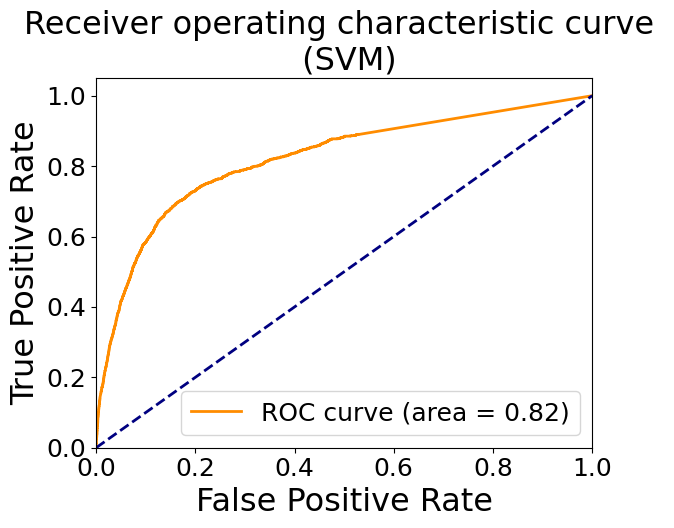

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,plot_roc_curve,roc_auc_score
def binary_encoder(x,number):
    if x == '1':
        return number
    else:
        return 0
def c_matrix(test_y, y_pred):
    return pd.DataFrame(confusion_matrix(test_y, y_pred),columns = ['Actual False','Actual True'],index=["Predicted False","Predicted True"])
matrices = dict()
fpr = dict()
tpr = dict()
thresholds = dict()
# for event in events:
#     pred = pred_df[event]
#     matrices[event] = c_matrix(y_holdout[event],pred)
#     fpr[event], tpr[event], thresholds[event] = roc_curve(y, pred, pos_label=2)

lw=2
sns.reset_orig()

fpr,tpr, _ = roc_curve(y_holdout['FirstDigitTouch'],predictions['FirstDigitTouch'][:, 1])
auc = roc_auc_score(y_holdout['FirstDigitTouch'],predictions['FirstDigitTouch'][:,1])
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=23)
plt.ylabel('True Positive Rate',fontsize=23)
plt.title('Receiver operating characteristic curve \n (SVM)',fontsize=23)
plt.legend(loc='lower right',fontsize=18)
plt.show()

In [32]:
f

array([nan, nan, nan])

In [28]:
y_holdout.FirstDigitTouch.value_counts()

0.0    44850
1.0     1950
Name: FirstDigitTouch, dtype: int64

In [ ]:
for event,matrix in zip(events,matrices.values()):
    print(event)
    display(matrix)

In [221]:
pd.concat([zX_train,zX_holdout])

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,TP9,CP5,CP1,CP2,CP6,TP10,P7,P3,Pz,P4
1999,-0.172931,0.291522,-0.136880,0.140039,-1.322081,0.537275,-0.258428,-0.479835,-1.211653,1.078696,...,0.621984,-0.476026,0.404312,0.310006,1.279832,1.213088,-0.983481,-0.082542,0.349646,0.944774
2000,-0.806892,-0.447097,-0.241175,0.014727,-1.535687,-0.340323,-0.167802,-0.419635,-1.569599,1.216202,...,0.470727,-0.679703,-0.014278,-0.343756,0.896060,0.837570,-0.626032,-0.468597,-0.071100,0.599465
2001,-1.019475,-0.520846,-0.114499,0.612167,-1.961207,0.665778,0.543746,0.248196,-0.547539,-0.503934,...,0.581964,-0.421287,0.136128,-0.448215,0.224089,1.343370,-0.167126,-0.101171,0.052839,0.535672
2002,-0.962817,-1.040714,-0.199704,1.164244,-1.662559,0.077006,0.593879,-0.336083,-0.304533,-0.171396,...,0.735654,-0.702278,0.520546,0.179397,0.794714,1.146280,-0.012783,0.095729,0.386890,0.840699
2003,-0.858129,-1.480707,-0.631671,0.711896,-1.811796,-0.374420,0.677881,-0.033202,-0.015514,-1.114567,...,0.576473,-0.485721,0.754307,-0.121581,0.558353,1.179658,-0.002723,0.104206,0.319481,0.713660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119491,0.097268,0.262057,-0.544124,0.020053,0.456755,-1.747506,0.729072,0.363242,-0.692286,-0.474861,...,-0.251154,-0.494636,-1.496654,-1.169591,-1.041705,-0.534789,-0.581118,-0.618757,-1.425637,-0.476347
119492,-0.003912,0.029618,-0.964513,0.118192,0.296738,0.546902,-0.057896,0.185955,-1.772656,-0.106750,...,-0.987609,-0.713521,-1.622609,-0.992188,-0.964543,-0.445461,-0.872029,-0.861114,-1.491075,-0.654290
119493,-0.200499,-0.236019,-1.070620,0.526657,0.247315,2.132738,-0.357019,-0.168362,-2.148055,0.366910,...,-0.717094,-0.641887,-1.828792,-1.301054,-0.907354,-0.049755,-1.056007,-0.943031,-1.640250,-0.541298
119494,-0.412459,-0.475099,-0.857729,0.662304,0.320427,1.938851,-0.908746,-0.088937,-1.796444,0.234327,...,-0.452578,-0.414336,-1.723922,-1.372456,-0.811201,-0.017862,-0.830590,-0.974940,-1.649558,-0.480113


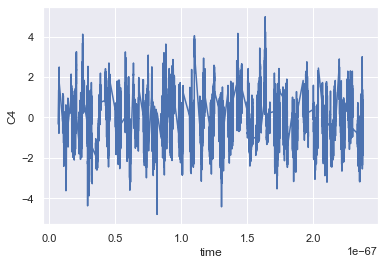

In [231]:
sns.lineplot(x=time,y=zX['C4'])

In [44]:
zX_train.to_csv("data/firstdigittouchScaled_trainingData.csv",index=True)
y_train.to_csv("data/firstdigittouch_y_train.csv",index=True)
zX_holdout.to_csv("data/firstdigittouchScaled_holdoutData.csv",index=True)
y_holdout.to_csv("data/firstdigittouch_y_holdout.csv",index=True)

In [47]:
pd.Series(predictions['FirstDigitTouch'][:,1]).to_csv("firstdigittouch_predictions.csv")